<a href="https://colab.research.google.com/github/AnguillaJaponica/FishQuolity/blob/main/fish_freshness.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 機械学習を使って魚の鮮度を考え抜く

[1. 記述統計](#explore) <br>
> [1.1 データを眺める](#prelim_explore) <br>
   [1.2 数値型のカラムを読む](#explore_num_columns) <br>
   [1.3 カテゴリカラムを読む](#explore_cat_columns)  <br>

[2. データのクリーニングと前処理](#data_clean)
> [2.1 欠損値のハンドリング](#fix_nans) <br>
   [2.2 外れ値を読む](#address_outliers)<br>
   [2.3 歪度を減らす](#transform_skew) <br>

[3. 特徴量の選定](#feature_eng)

[4. モデル作成](#algorithms)

[5. モデルの選定とチューニング](#fine_tune)

(#TODO: aタグつけて、各箇所に飛べるようにする)


In [ ]:
# コアモジュール
import pandas as pd
import numpy as np

# データの可視化
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [ ]:
# google driveをマウント。ファイルを置く場所に応じて、ディレクトリを変えてください。今はルートになってます。
from google.colab import drive
drive.mount('/content/drive')
fish_data = pd.read_csv('drive/My Drive/freshness_prediction.csv', encoding="utf-8")

Mounted at /content/drive


In [ ]:
# fish_name: 魚種名(学名)
# storage_temperature: 貯蔵温度
# K0: 非常に新鮮な魚肉のk値
# Tt: t℃ 保存における刺身としての許容日数
# K2: 刺身として食せる許容(限界)のK値,Tt
# K_dash: 現時点でのk値
# RVD: 魚肉の生可食限界値

fish_data.head()

,id,fish_name,storage_temperature,K0,Tt,K2,K_dash,RVD
0,1,Pagrus major,-10.0,5.5,40.0,20,15,15.0
1,2,Pagrus major,-2.0,4.8,23.0,20,15,7.5
2,3,Pagrus major,0.0,6.5,10.0,20,15,3.9
3,4,Pagrus major,0.0,6.7,5.0,20,15,1.8
4,5,Pagrus major,0.0,0.5,420.0,20,15,108.0


In [ ]:
fish_data.tail()

,id,fish_name,storage_temperature,K0,Tt,K2,K_dash,RVD
82,83,Katuwonus pelamis,0.5,4.0,5.7,35,30,1.00
83,84,Katuwonus pelamis,5.0,22.0,1.8,35,30,0.70
84,85,Katuwonus pelamis,5.0,25.0,1.9,35,30,0.80
85,86,Katuwonus pelamis,10.0,25.0,0.5,35,30,0.21
86,87,Katuwonus pelamis,15.0,8.8,1.1,35,30,0.24


In [ ]:
# データの型
fish_data.shape

(87, 8)

In [ ]:
# 数値のカラムを抽出する。
fish_data.select_dtypes(exclude=['object']).columns

Index(['id', 'storage_temperature', 'K0', 'Tt', 'K2', 'K_dash', 'RVD'], dtype='object')

In [ ]:
# 数値のカラム数
len(fish_data.select_dtypes(exclude='object').columns)

7

In [ ]:
# 数値のカラムに関する特徴量を調べる
fish_data.select_dtypes(exclude=['object']).describe().round(decimals=2)

,id,storage_temperature,K0,Tt,K2,K_dash,RVD
count,87.00,87.00,87.00,87.00,87.00,87.00,87.00
mean,44.00,1.57,9.07,15.33,22.24,17.24,6.51
std,25.26,7.22,7.12,62.57,5.38,5.38,25.49
min,1.00,-20.00,0.00,0.02,20.00,15.00,0.01
25%,22.50,0.00,4.80,1.90,20.00,15.00,0.82
50%,44.00,0.00,8.00,3.90,20.00,15.00,1.20
75%,65.50,5.00,11.00,5.80,20.00,15.00,2.60
max,87.00,32.00,38.00,420.00,35.00,30.00,213.00


In [ ]:
# カテゴリのカラムを抽出する。
fish_data.select_dtypes(include=['object']).columns

Index(['fish_name'], dtype='object')

In [ ]:
# カテゴリのカラム数
len(fish_data.select_dtypes(include='object').columns)

1

In [ ]:
# カテゴリカラムに関する特徴量を調べる
fish_data.select_dtypes(include=['object']).describe()

,fish_name
count,87
unique,5
top,Scomber japonicus
freq,31


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


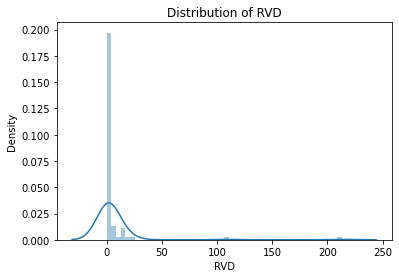

In [ ]:
# RVDデータの偏りを調べる
target = fish_data.RVD
plt.figure()
sns.distplot(target)
plt.title('Distribution of RVD')
plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


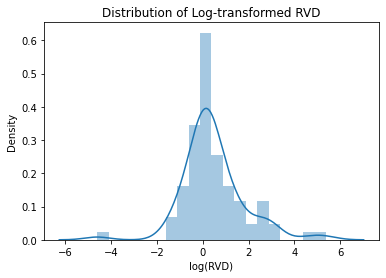

In [ ]:
# 対数変換して歪度を減らす。
# 線形回帰だと重要だが決定木やRDだと補正の必要はない。
# 今回は比較対象として線形回帰も入っているのでやる。
sns.distplot(np.log(target))
plt.title('Distribution of Log-transformed RVD')
plt.xlabel('log(RVD)')
plt.show()

In [ ]:
# 対数変換してどれくらい歪度減ったのかを表示。
print('RVD has a skew of ' + str(target.skew().round(decimals=2)) + 
      ' while the log-transformed RVD improves the skew to ' + 
      str(np.log(target).skew().round(decimals=2)))

RVD has a skew of 7.08 while the log-transformed RVD improves the skew to 0.61


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

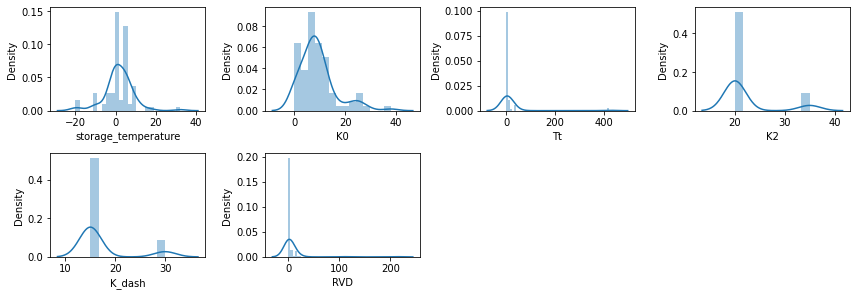

In [ ]:
# 各カラムごとの特徴を掴む。IDは別に知らなくていいから排除。

num_attributes = fish_data.select_dtypes(exclude='object').drop(['id'], axis=1).copy()

fig = plt.figure(figsize=(12,18))
for i in range(len(num_attributes.columns)):
    fig.add_subplot(9,4,i+1)
    sns.distplot(num_attributes.iloc[:,i].dropna())
    plt.xlabel(num_attributes.columns[i])

plt.tight_layout()
plt.show()

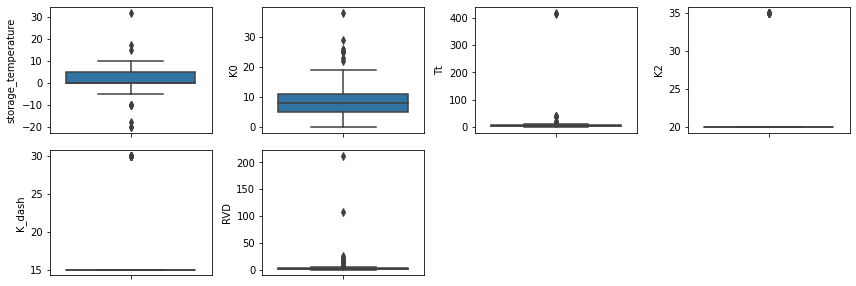

In [ ]:
# 各カラムの箱ひげ図
fig = plt.figure(figsize=(12, 18))

for i in range(len(num_attributes.columns)):
    fig.add_subplot(9, 4, i+1)
    sns.boxplot(y=num_attributes.iloc[:,i])

plt.tight_layout()
plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-package

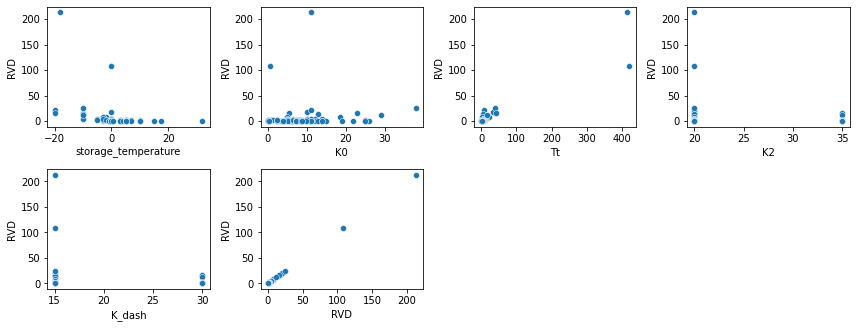

In [ ]:
# RVDと各カラムとの散布図
f = plt.figure(figsize=(12,20))

for i in range(len(num_attributes.columns)):
    f.add_subplot(9, 4, i+1)
    sns.scatterplot(num_attributes.iloc[:,i], target)
    
plt.tight_layout()
plt.show()

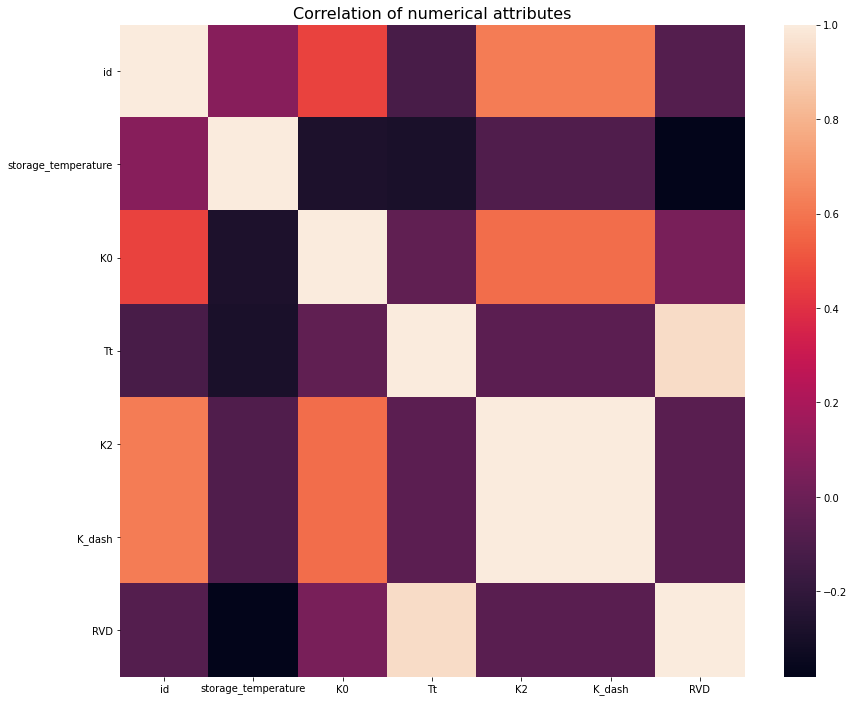

In [ ]:
# 相関のヒートマップ
# 線形回帰をモデリングに使用するには、モデルを改善するために相関のある変数を削除する必要があることが多いので、そのあぶり出しに。
correlation = fish_data.corr()

f, ax = plt.subplots(figsize=(14,12))
plt.title('Correlation of numerical attributes', size=16)
sns.heatmap(correlation)
plt.show()


In [ ]:
# RVDと相関が強いものランキング。
# Tt(刺身としての許容日数)が長ければ長いほどRVDは長い(そりゃそう)。
# storage_temperatureが低いほど、RVDは長い(そりゃそう)。
correlation['RVD'].sort_values(ascending=False).head(10)

RVD                    1.000000
Tt                     0.941024
K0                     0.042915
K_dash                -0.060150
K2                    -0.060150
id                    -0.075570
storage_temperature   -0.381049
Name: RVD, dtype: float64

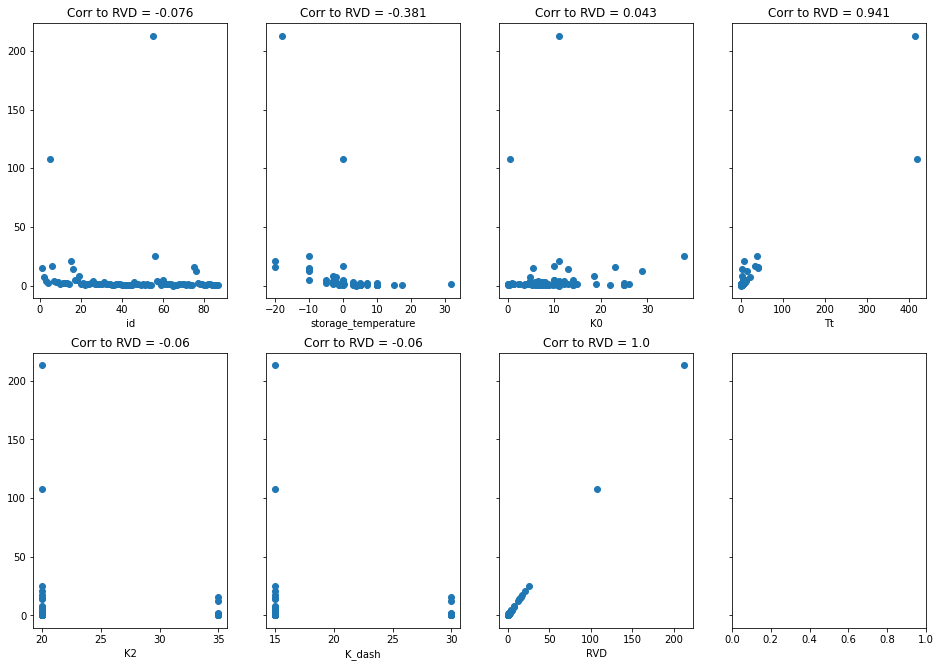

In [ ]:
# もっかい散布図を見てみる
num_columns = fish_data.select_dtypes(exclude='object').columns
corr_to_price = correlation['RVD']
n_cols = 4
n_rows = 2
fig, ax_arr = plt.subplots(n_rows, n_cols, figsize=(16,5), sharey=True)
plt.subplots_adjust(bottom=-0.8)
for j in range(n_rows):
    for i in range(n_cols):
        plt.sca(ax_arr[j, i])
        index = i + j*n_cols
        if index < len(num_columns):
            plt.scatter(fish_data[num_columns[index]], fish_data.RVD)
            plt.xlabel(num_columns[index])
            plt.title('Corr to RVD = '+ str(np.around(corr_to_price[index], decimals=3)))
plt.show()

In [ ]:
# null値のものがあるかチェック。
num_attributes.isna().sum().sort_values(ascending=False).head()

RVD       0
K_dash    0
K2        0
Tt        0
K0        0
dtype: int64

In [ ]:
# カテゴリカラムの確認
cat_columns = fish_data.select_dtypes(include='object').columns
print(cat_columns)

Index(['fish_name'], dtype='object')


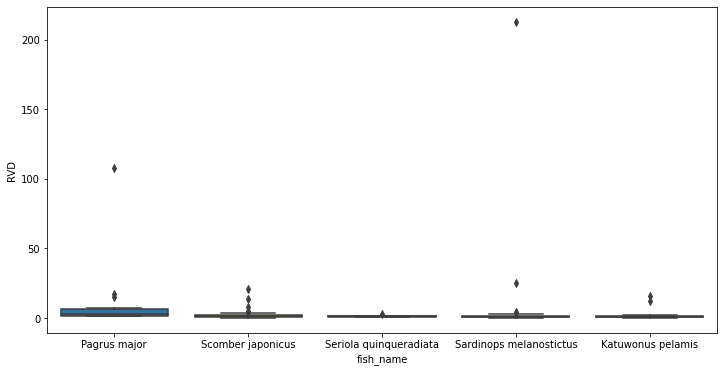

In [ ]:
# 魚種ごとのRVDの観察。
var = fish_data['fish_name']
f, ax = plt.subplots(figsize=(12,6))
sns.boxplot(y=fish_data.RVD, x=var)
plt.show()

In [ ]:
# データのクリーニングと前処理に使うライブラリのインポート
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

In [ ]:
# 元データを壊さないように、コピーをいじる。
fish_data_copy = fish_data.copy()

In [ ]:
# 対数変換して、カラム名を変えておく
fish_data_copy['RVD'] = np.log(fish_data_copy['RVD'])
fish_data_copy = fish_data_copy.rename(columns={'RVD': 'RVD_log'})

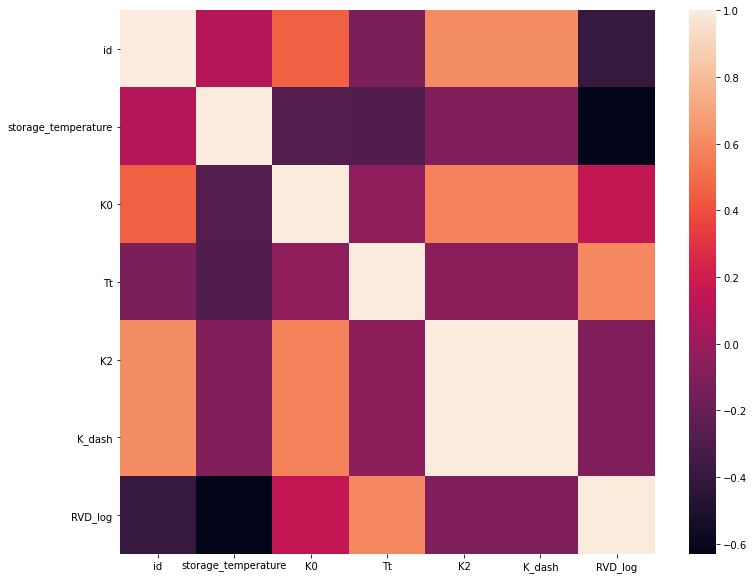

In [ ]:
# 対数変換後の相関を確認
transformed_corr = fish_data_copy.corr()
plt.figure(figsize=(12,10))
sns.heatmap(transformed_corr)

In [ ]:
# 学習データの作成
y =  fish_data_copy.RVD_log

attributes_drop = ['id'] 
X = fish_data_copy.drop(attributes_drop, axis=1)

# idカラムは使わない。魚種名はワンホット表現に変換。
X = pd.get_dummies(X)
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)

# 今回のデータセットは欠損値はないが、どの道後から出てくるので入れとく
my_imputer = SimpleImputer()
train_X = my_imputer.fit_transform(train_X)
val_X = my_imputer.transform(val_X)

X.head()

,storage_temperature,K0,Tt,K2,K_dash,RVD_log,fish_name_Katuwonus pelamis,fish_name_Pagrus major,fish_name_Sardinops melanostictus,fish_name_Scomber japonicus,fish_name_Seriola quinqueradiata
0,-10.0,5.5,40.0,20,15,2.708050,0,1,0,0,0
1,-2.0,4.8,23.0,20,15,2.014903,0,1,0,0,0
2,0.0,6.5,10.0,20,15,1.360977,0,1,0,0,0
3,0.0,6.7,5.0,20,15,0.587787,0,1,0,0,0
4,0.0,0.5,420.0,20,15,4.682131,0,1,0,0,0


In [ ]:
# 機械学習アルゴリズムの評価/選定
from sklearn.metrics import mean_absolute_error

from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor

In [ ]:
def inv_y(transformed_y):
    return np.exp(transformed_y)

# 各アルゴリズムの平均絶対誤差を確認する.
mae_compare = pd.Series()
mae_compare.index.name = 'Algorithm'

# ランダムフォレスト=============================
rf_model = RandomForestRegressor(random_state=5)
rf_model.fit(train_X, train_y)
rf_val_predictions = rf_model.predict(val_X)
rf_val_mae = mean_absolute_error(inv_y(rf_val_predictions), inv_y(val_y))

mae_compare['RandomForest'] = rf_val_mae

# XGBoost======================================
xgb_model = XGBRegressor(n_estimators=1000, learning_rate=0.005)
xgb_model.fit(train_X, train_y, early_stopping_rounds=5, 
              eval_set=[(val_X,val_y)], verbose=False)
xgb_val_predictions = xgb_model.predict(val_X)
xgb_val_mae = mean_absolute_error(inv_y(xgb_val_predictions), inv_y(val_y))

mae_compare['XGBoost'] = xgb_val_mae

# 線形回帰=================================================
linear_model = LinearRegression()
linear_model.fit(train_X, train_y)
linear_val_predictions = linear_model.predict(val_X)
linear_val_mae = mean_absolute_error(inv_y(linear_val_predictions), inv_y(val_y))

mae_compare['LinearRegression'] = linear_val_mae

# ラッソ回帰==============================================================
lasso_model = Lasso(alpha=0.0005, random_state=5)
lasso_model.fit(train_X, train_y)
lasso_val_predictions = lasso_model.predict(val_X)
lasso_val_mae = mean_absolute_error(inv_y(lasso_val_predictions), inv_y(val_y))

mae_compare['Lasso'] = lasso_val_mae

# リッジ回帰===============================================================
ridge_model = Ridge(alpha=0.0002, random_state=5)
ridge_model.fit(train_X, train_y)
ridge_val_predictions = ridge_model.predict(val_X)
ridge_val_mae = mean_absolute_error(inv_y(ridge_val_predictions), inv_y(val_y))

mae_compare['Ridge'] = ridge_val_mae

# ElasticNet===========================================================
elastic_net_model = ElasticNet(alpha=0.02, random_state=5, l1_ratio=0.7)
elastic_net_model.fit(train_X, train_y)
elastic_net_val_predictions = elastic_net_model.predict(val_X)
elastic_net_val_mae = mean_absolute_error(inv_y(elastic_net_val_predictions), inv_y(val_y))

mae_compare['ElasticNet'] = elastic_net_val_mae

# 勾配ブースティング==========================================
gbr_model = GradientBoostingRegressor(n_estimators=300, learning_rate=0.05, 
                                      max_depth=4, random_state=5)
gbr_model.fit(train_X, train_y)
gbr_val_predictions = gbr_model.predict(val_X)
gbr_val_mae = mean_absolute_error(inv_y(gbr_val_predictions), inv_y(val_y))

mae_compare['GradientBoosting'] = gbr_val_mae

print('MAE values for different algorithms:')
mae_compare.sort_values(ascending=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """


[11:30:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MAE values for different algorithms:


Algorithm
LinearRegression    3.324361e-15
Ridge               4.368322e-06
Lasso               2.792421e-04
ElasticNet          1.071004e-02
GradientBoosting    3.702803e-02
XGBoost             4.454938e-02
RandomForest        7.083150e-02
dtype: float64

In [ ]:
# クロスバリデーション
# ラッソ回帰
from sklearn.model_selection import cross_val_score

imputer = SimpleImputer()
imputed_X = imputer.fit_transform(X)
n_folds = 10

# =========================================================================
scores = cross_val_score(lasso_model, imputed_X, y, scoring='neg_mean_squared_error', 
                         cv=n_folds)
lasso_mae_scores = np.sqrt(-scores)

print('For LASSO model:')
# print(lasso_mae_scores.round(decimals=2))
print('Mean RMSE = ' + str(lasso_mae_scores.mean().round(decimals=3)))
print('Error std deviation = ' +str(lasso_mae_scores.std().round(decimals=3)))

For LASSO model:
Mean RMSE = 0.001
Error std deviation = 0.0


In [ ]:
# クロスバリデーション
# 勾配ブースティング
scores = cross_val_score(gbr_model, imputed_X, y, scoring='neg_mean_squared_error', 
                         cv=n_folds)
gbr_mae_scores = np.sqrt(-scores)

print('For Gradient Boosting model:')
# print(lasso_mae_scores.round(decimals=2))
print('Mean RMSE = ' + str(gbr_mae_scores.mean().round(decimals=3)))
print('Error std deviation = ' +str(gbr_mae_scores.std().round(decimals=3)))

For Gradient Boosting model:
Mean RMSE = 0.227
Error std deviation = 0.333


In [ ]:
# クロスバリデーション
# XGBoost
scores = cross_val_score(xgb_model, imputed_X, y, scoring='neg_mean_squared_error', 
                         cv=n_folds)
mae_scores = np.sqrt(-scores)

print('For XGBoost model:')
# print(mae_scores.round(decimals=2))
print('Mean RMSE = ' + str(mae_scores.mean().round(decimals=3)))
print('Error std deviation = ' +str(mae_scores.std().round(decimals=3)))

[11:24:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:24:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:24:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:24:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:24:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:24:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:24:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:24:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

In [ ]:
# クロスバリデーション
# ランダムフォレスト
scores = cross_val_score(rf_model, imputed_X, y, scoring='neg_mean_squared_error', 
                         cv=n_folds)
mae_scores = np.sqrt(-scores)

print('For Random Forest model:')
# print(mae_scores.round(decimals=2))
print('Mean RMSE = ' + str(mae_scores.mean().round(decimals=3)))
print('Error std deviation = ' +str(mae_scores.std().round(decimals=3)))

For Random Forest model:
Mean RMSE = 0.276
Error std deviation = 0.354


In [ ]:
# ハイパーパラメータのチューニング
# XGBoostでおく
from sklearn.model_selection import GridSearchCV

# # Tuning XGBoost
param_grid = [{'n_estimators': [1000, 1500, 2000], 'learning_rate': [0.005, 0.01, 0.03] }]
# #               'max_depth': [3, 6, 9]}]

top_reg = XGBRegressor()

# -------------------------------------------------------
grid_search = GridSearchCV(top_reg, param_grid, cv=5, 
                           scoring='neg_mean_squared_error')

grid_search.fit(imputed_X, y)

grid_search.best_params_

[11:29:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:29:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:29:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:29:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:29:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:29:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:29:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:29:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

{'learning_rate': 0.005, 'n_estimators': 1000}

In [ ]:
# テストデータで検証